## Credit-Scoring dataset: Data scaling and split. Modelling and Evaluation

#### 1. Importing libraries and cleaned dataset

In [221]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns   
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score



df = pd.read_csv("../data/processed/cs-scoring-processed.csv", index_col=False)
print("First 5 rows of the dataset:")
print(df.head())

First 5 rows of the dataset:
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0                 1                              0.766127   45   
1                 0                              0.957151   40   
2                 0                              0.658180   38   
3                 0                              0.233810   30   
4                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
0                                     2   0.802982         9120.0   
1                                     0   0.121876         2600.0   
2                                     1   0.085113         3042.0   
3                                     0   0.036050         3300.0   
4                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
0                               13                        0   
1                                

#### 2. Creating function for dataset scaling

In [ ]:
# def dataset_scaler(data):
#     scaler = MinMaxScaler()
#     scaled_data = scaler.fit_transform(data)
#     scaled_df = pd.DataFrame(scaled_data, columns=data.columns)
#     return scaled_df


repo_root = Path.cwd().resolve().parent   # repo root when notebook is in 'notebooks'
sys.path.append(str(repo_root))

from src.modelling import dataset_scaler

>>>> Dataset_scaler function is applied to scoring dataset

In [223]:
data = df.iloc[:, df.columns != 'SeriousDlqin2yrs']

scaled_features = dataset_scaler(data)

>>>> Here is the scaled dataset

In [224]:
df_feat = pd.DataFrame(scaled_features,columns=df.columns[1:])
df_feat.head()

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,0.000015,0.412844,0.020408,1.314070e-05,0.003031,0.224138,0.000000,0.111111,0.0,0.10
1,0.000019,0.366972,0.000000,1.994488e-06,0.000864,0.068966,0.000000,0.000000,0.0,0.05
2,0.000013,0.348624,0.010204,1.392869e-06,0.001011,0.034483,0.010204,0.000000,0.0,0.00
3,0.000005,0.275229,0.000000,5.899484e-07,0.001097,0.086207,0.000000,0.000000,0.0,0.00
4,0.000018,0.449541,0.010204,4.079058e-07,0.021134,0.120690,0.000000,0.018519,0.0,0.00


#### 3. Splitting dataset into train and test

In [225]:
X_train, X_test, y_train, y_test = train_test_split(scaled_features,df['SeriousDlqin2yrs'],
                                                    test_size=0.20)

## Logistic Regression

#### 1.Train logistic Regression model on train data

In [226]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

LogisticRegression()

#### 2. Get predictions of trained Logistic Regression Model on test data

In [227]:
log_predictions = logmodel.predict(X_test)

#### 3. Evaluate quality of prediction using classification report and confusion matrix

In [228]:
print(classification_report(y_test,log_predictions))
print(confusion_matrix(y_test,log_predictions))

              precision    recall  f1-score   support

           0       0.93      1.00      0.97     27995
           1       0.63      0.02      0.03      2005

    accuracy                           0.93     30000
   macro avg       0.78      0.51      0.50     30000
weighted avg       0.91      0.93      0.90     30000

[[27975    20]
 [ 1971    34]]


#### 4. Count Roc AUC Score

In [229]:
auc = roc_auc_score(y_test, logmodel.decision_function(X_test))
print("ROC AUC:", auc)

ROC AUC: 0.6683456744814157


#### 5. Create a function for ROC-curve visualization

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

def plot_roc_curve(input_model, X_test, y_test):

  # Probabilities for the positive class (class 1)
  y_scores = input_model.predict_proba(X_test)[:, 1]

  # Compute ROC curve and ROC AUC score
  fpr, tpr, thresholds = roc_curve(y_test, y_scores)
  auc = roc_auc_score(y_test, y_scores)
  
  # Plot
  plt.figure(figsize=(8, 6))
  plt.plot(fpr, tpr, label=f'Logistic ROC (AUC = {auc:.3f})', linewidth=2)
  plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC Curve - Logistic Regression')
  plt.legend(loc='lower right')
  plt.grid(True)
  plt.show()

#### 6. Use the function to visualize ROC curve

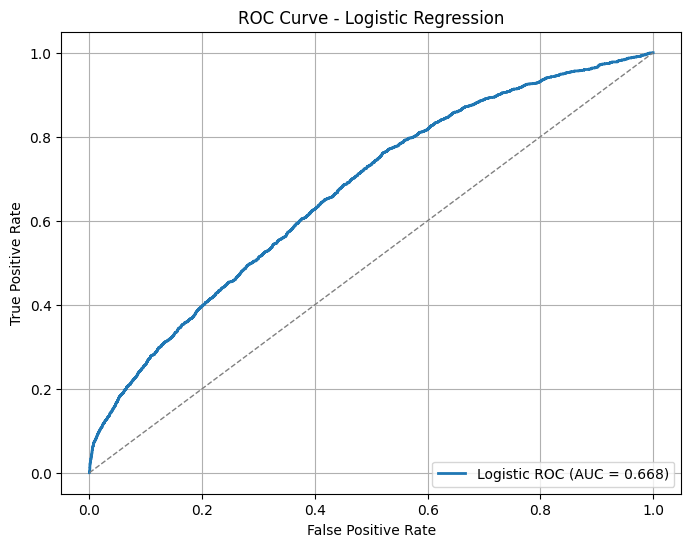

In [232]:
plot_roc_curve(logmodel, X_test, y_test)

<Axes: xlabel='Importance', ylabel='Feature'>

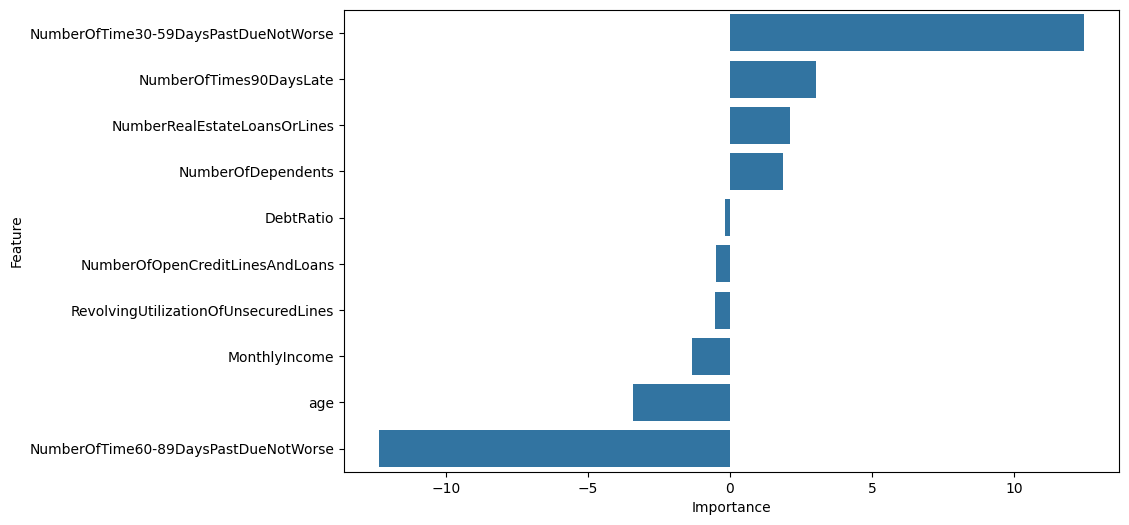

In [233]:
    importances = logmodel.coef_[0]
    feature_names = df.columns[1:]  
model_coefficients = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
model_coefficients = model_coefficients.sort_values(by='Importance', ascending=False)   
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=model_coefficients)   

## Random Forest

#### 1. Import libraries

In [234]:
from sklearn.ensemble import RandomForestClassifier

#### 2. Train the model

In [ ]:
rfc = RandomForestClassifier(n_estimators=600)
rfc.fit(X_train,y_train)

#### 3. Get predicted data

In [ ]:

rfc_predictions = rfc.predict(X_test)

#### 4. Evaluate quality of prediction using classification report and confusion matrix

In [237]:
print(confusion_matrix(y_test,rfc_predictions))
print("/")
print(classification_report(y_test,rfc_predictions))

[[27676   319]
 [ 1612   393]]
/
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.55      0.20      0.29      2005

    accuracy                           0.94     30000
   macro avg       0.75      0.59      0.63     30000
weighted avg       0.92      0.94      0.92     30000



#### 5. Count Roc AUC Score

In [238]:
auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print("ROC AUC:", auc)

ROC AUC: 0.8464251854735372


#### 6. Use the function to visualize ROC curve

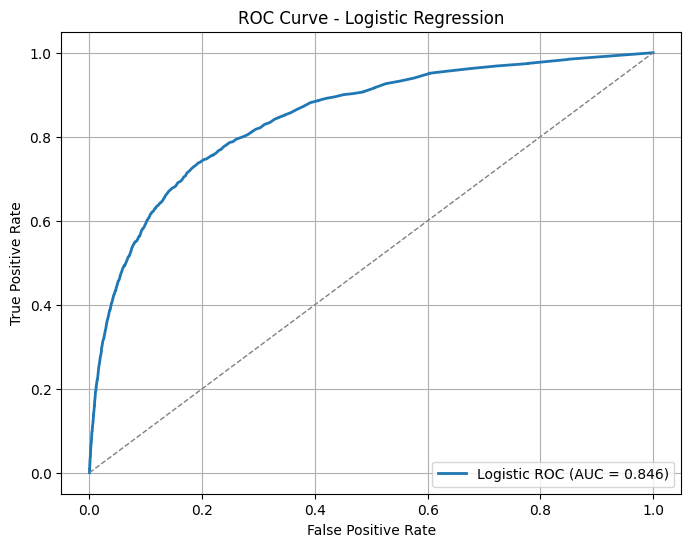

In [247]:
plot_roc_curve(rfc, X_test, y_test)

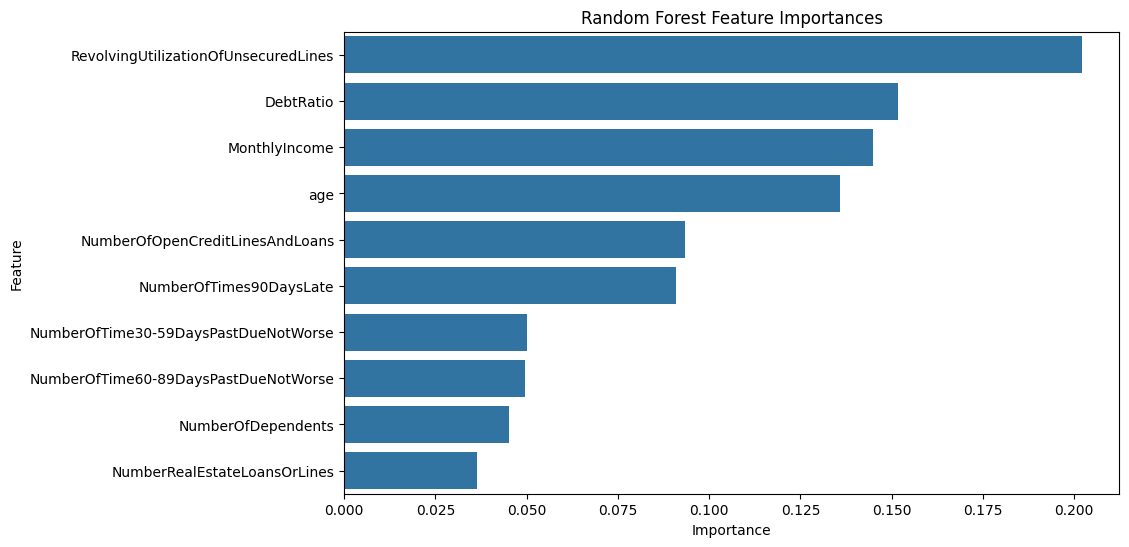

In [249]:
# Get feature importances and labels, sort by importance
rfc_importances = rfc.feature_importances_
feat_labels = df.columns[1:]
feat_imp_df = pd.DataFrame({'feature': feat_labels, 'importance': rfc_importances})
feat_imp_df = feat_imp_df.sort_values(by='importance', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feat_imp_df)
plt.title('Random Forest Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

## XGBoost (eXtreme Gradient Boosting)

In [250]:
import xgboost as xgb
from sklearn.metrics import accuracy_score


In [251]:
xgb_train = xgb.DMatrix(X_train, y_train, enable_categorical=True)
xgb_test = xgb.DMatrix(X_test, y_test, enable_categorical=True)

In [ ]:
params = {
    'objective': 'binary:logistic',
    'max_depth': 3,
    'learning_rate': 0.1,
}
n=50
xgb_model = xgb.train(params=params,dtrain=xgb_train,num_boost_round=n)

In [ ]:
xgb_preds = xgb_model.predict(xgb_test)
xgb_preds = np.round(xgb_preds)
accuracy= accuracy_score(y_test,xgb_preds)
print('Accuracy of the model is:', accuracy*100)

Accuracy of the model is: 93.8


In [254]:
print(confusion_matrix(y_test,xgb_preds))
print("/")
print(classification_report(y_test,xgb_preds))

[[27819   176]
 [ 1684   321]]
/
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     27995
           1       0.65      0.16      0.26      2005

    accuracy                           0.94     30000
   macro avg       0.79      0.58      0.61     30000
weighted avg       0.92      0.94      0.92     30000



In [ ]:
# model is xgboost.Booster, xgb_test is DMatrix
y_proba = xgb_model.predict(xgb_test)           # probabilities for the positive class (with 'binary:logistic')
auc = roc_auc_score(y_test, y_proba)
print("XGBoost ROC AUC:", auc)

XGBoost ROC AUC: 0.8603887584129514


In [ ]:
plot_roc_curve(xgb_model, X_test, y_test)